In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt

#loading data
file_1="/workspaces/State-of-Health-Estimation-Battery/Dataset/B0005_dis_dataset.csv"
dataset=pd.read_csv(file_1)

#making dataframes
dataset["Soh"]=dataset["capacity"]/dataset["capacity"][0]
X=["cycle","capacity","voltage_measured","current_measured","temperature_measured","current_load","voltage_load","time"]

In [2]:
cor = dataset.corr()

<Axes: >

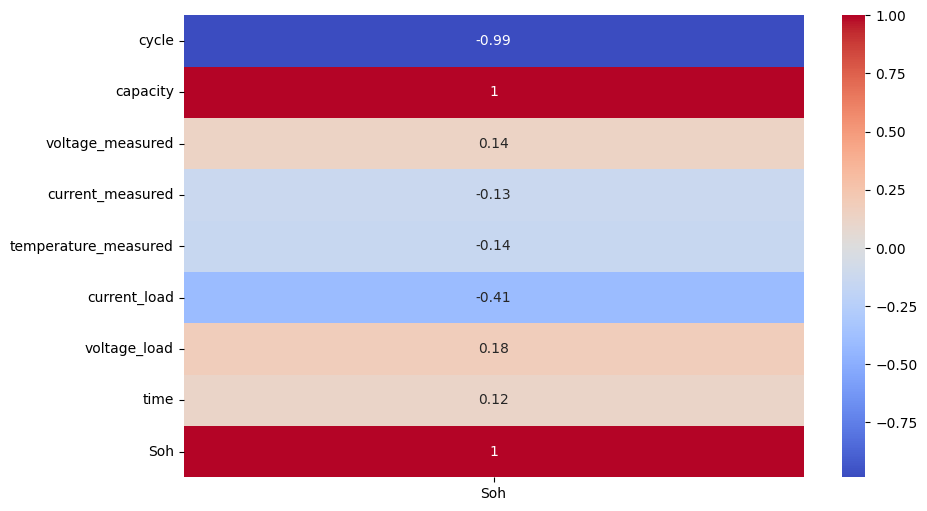

In [4]:
plt.figure(figsize=(10,6))  #select value out of range(0.05,-0.05)
sns.heatmap(cor[["Soh"]],annot=True,cmap='coolwarm')
#cycle,current_load

In [5]:
from sklearn.feature_selection import mutual_info_regression

In [6]:
def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y,)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [7]:
mi_scores = make_mi_scores(dataset[X],dataset[["Soh"]])

/home/codespace/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [8]:
mi_scores

cycle                   5.110594
capacity                5.104347
current_load            0.529113
current_measured        0.027223
voltage_measured        0.000000
temperature_measured    0.000000
voltage_load            0.000000
time                    0.000000
Name: MI Scores, dtype: float64

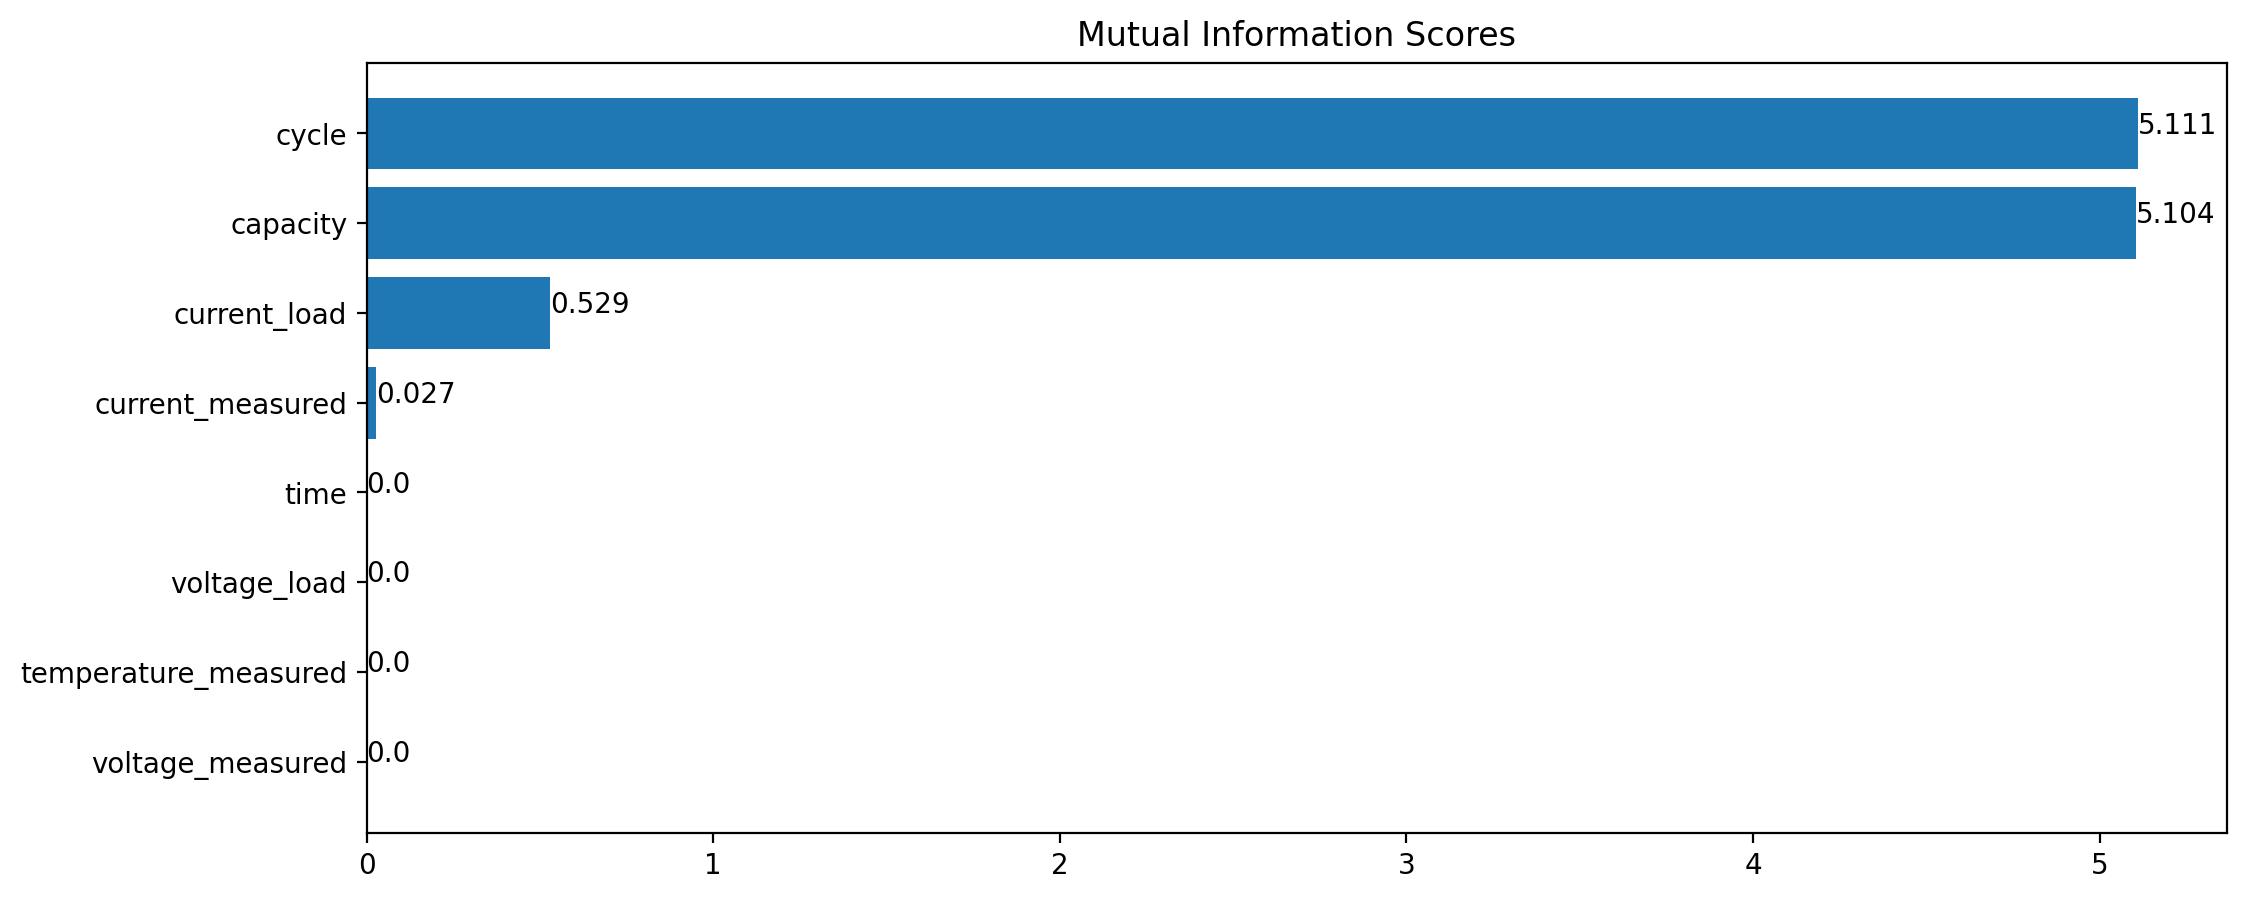

In [10]:
def plot_mi_scores(scores):
    plt.figure(dpi=200, figsize=(12, 5))
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    for index, value in enumerate(scores):
        plt.text(value, index,str(round(value,3)))
plot_mi_scores(mi_scores)